In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast


from sklearn.model_selection import train_test_split, validation_curve
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from scipy.stats import norm
from scipy.optimize import minimize


df = pd.read_csv(r"C:\Users\jjap2\Poleto SCE\Poleto-SCE\dond_game_data.csv")

In [2]:
#cleaning cell
df["Remaining Values"] = df["Remaining Values"].apply(ast.literal_eval)

all_values = set()
for values in df["Remaining Values"]:
    all_values.update(values)

for value in sorted(all_values):
    df[f"Case_{value}"] = df["Remaining Values"].apply(lambda x: 1 if value in x else 0)

exclude = ["Remaining Values", "Contestant Name", "Contestant Gender", "Contestant Race", "Amount Won"]
df = df.drop(columns=exclude)
# df.drop(columns=["Remaining Values"], inplace=True)
# df.drop(columns=["Contestant Name"], inplace=True)

df = df[(df["Postgame"] != 1) & (df["Offer"] != 0)]


In [3]:
# defining variables
X = df.drop(columns=["Offer"])
y = df["Offer"]

In [4]:
# standardize!
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

lasso = LassoCV(cv=5, random_state=42).fit(X_train, y_train)

In [6]:
Alpha = lasso.alpha_
lasso_coefs = lasso.coef_

print("Alpha:", Alpha)
print("LASSO Coefficients:", lasso_coefs)

Alpha: 85.32105188323042
LASSO Coefficients: [-6.83517864e+02 -4.58517947e+03 -3.27047396e+04  8.50813942e+04
 -9.06730647e+01  7.07607283e+03  3.60691022e+04  0.00000000e+00
  0.00000000e+00  8.35310976e+03  3.76244747e+03  3.49414490e+03
  7.58825019e+02  3.52949983e+03  3.31345694e+03 -0.00000000e+00
  2.85160538e+03  3.54644205e+03  3.17523283e+03  1.27218665e+03
  3.31982759e+03  2.93852032e+03  1.84716607e+03  3.22814559e+03
  1.47889252e+03  8.84245946e+00  1.95337626e+03  0.00000000e+00
  0.00000000e+00  4.00813077e+03  2.34459495e+03  0.00000000e+00
  3.10550661e+03  2.17787726e+03  1.40303038e+03  1.65491744e+02
  1.04334976e+03 -0.00000000e+00 -2.01985033e+03 -0.00000000e+00
  0.00000000e+00  4.72335986e+00  1.00807427e+02 -1.04290780e+03
 -7.27330181e+02 -2.71604986e+03  0.00000000e+00 -7.65024845e+02
 -0.00000000e+00 -7.84448556e+03]


In [7]:
nz_feats = X.columns[lasso.coef_ != 0]
nz_coefs = lasso.coef_[lasso.coef_ != 0]
nz_feat_list = list(zip(nz_feats, nz_coefs))
nz_feat_list.sort(key=lambda x: abs(x[1]), reverse=True)

print("Important Features and Their LASSO Coefficients:")
for feature, coef in nz_feat_list:
    print(f"{feature}: {coef:.4f}")


Important Features and Their LASSO Coefficients:
Board Average: 85081.3942
Offer Percent of Average: 36069.1022
Board Value: -32704.7396
Probability of Big Value: 8353.1098
Case_6000000: -7844.4856
Previous Offer: 7076.0728
Round: -4585.1795
Case_5000: 4008.1308
Case_0: 3762.4475
Case_50: 3546.4420
Case_5: 3529.4998
Case_1: 3494.1449
Case_200: 3319.8276
Case_10: 3313.4569
Case_500: 3228.1456
Case_75: 3175.2328
Case_25000: 3105.5066
Case_300: 2938.5203
Case_25: 2851.6054
Case_1000000: -2716.0499
Case_10000: 2344.5950
Case_50000: 2177.8773
Case_250000: -2019.8503
Case_1000: 1953.3763
Case_400: 1847.1661
Case_750: 1478.8925
Case_75000: 1403.0304
Case_100: 1272.1866
Case_150000: 1043.3498
Case_750000: -1042.9078
Case_2000000: -765.0248
Case_2: 758.8250
Case_800000: -727.3302
Game ID: -683.5179
Case_100000: 165.4917
Case_600000: 100.8074
Board Balance: -90.6731
Case_800: 8.8425
Case_500000: 4.7234


In [8]:
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}")
print(f"Train R²: {train_r2:.2f}, Test R²: {test_r2:.2f}")

Train MSE: 137182415.79, Test MSE: 197587833.71
Train R²: 0.98, Test R²: 0.97


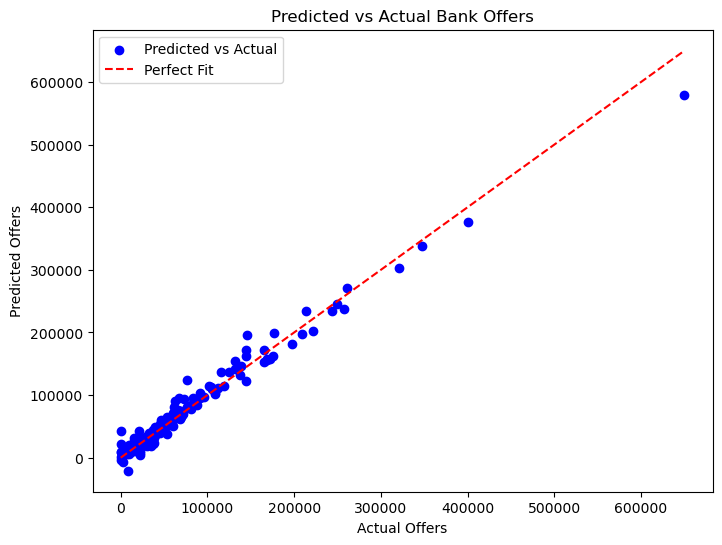

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Fit")
plt.xlabel("Actual Offers")
plt.ylabel("Predicted Offers")
plt.title("Predicted vs Actual Bank Offers")
plt.legend()
plt.show()

In [10]:
results = df.loc[y_test.index, ["Game ID", "Round"]].copy()
results["Actual Offer"] = y_test.values
results["Predicted Offer"] = y_test_pred
negative_predictions = results[results["Predicted Offer"] < 0]

print(negative_predictions)


     Game ID  Round  Actual Offer  Predicted Offer
136       24      9         500.0     -3058.924068
821      107      3        8700.0    -20834.399766
376       51      8        3000.0     -7448.539061


c:\Users\jjap2\Anaconda\envs\phillies\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.516e+10, tolerance: 2.878e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\jjap2\Anaconda\envs\phillies\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.448e+10, tolerance: 2.878e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\jjap2\Anaconda\envs\phillies\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularis

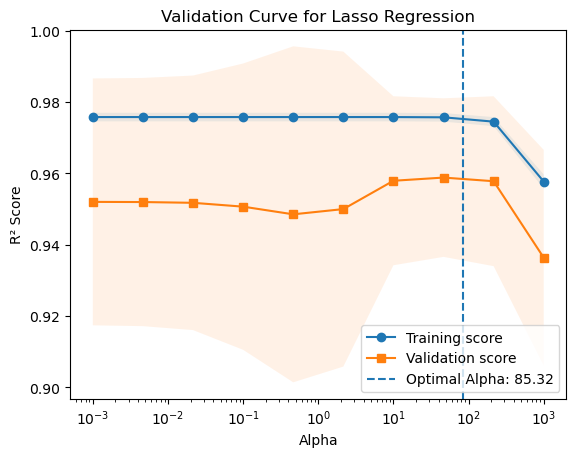

In [ ]:
alpha_range = np.logspace(-3, 3, 10)  # log-spaced values for better scale

# validation curve
train_scores, test_scores = validation_curve(
    Lasso(max_iter=5000), X_train, y_train, param_name="alpha", param_range=alpha_range, cv=10, scoring="r2"
)

# mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.plot(alpha_range, train_mean, label="Training score", marker='o')
plt.plot(alpha_range, test_mean, label="Validation score", marker='s')
plt.fill_between(alpha_range, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(alpha_range, test_mean - test_std, test_mean + test_std, alpha=0.1)

plt.xscale("log") 
plt.xlabel("Alpha")
plt.ylabel("R² Score")
plt.title("Validation Curve for Lasso Regression")
plt.axvline(Alpha, linestyle='--', label=f'Optimal Alpha: {Alpha:.2f}')
plt.legend()
plt.show()